In [1]:
import numpy as np


"""
Toy model of an on-chain ecosystem with two tokens and one DEX.
Transactions on the DEX create an opportunity for sandwich attacks.
"""
class ExecutionException(Exception):
    pass
def require(cond, msg=None):
    if not cond: raise ExecutionException(msg)

# This is the basic Uniswap v2 rule
def pool_swap(poolA, poolB, amtA):
    # Solve the constant product poolA*poolB == (poolA+amtA)*(poolB+amtB)
    # Convention: +amtA means amtA is added to the pool
    amtB = poolA*poolB / (poolA + amtA) - poolB
    assert np.isclose(poolA*poolB, (poolA + amtA)*(poolB + amtB))

    # Truncate to 4 decimal places
    return round(amtB*1e4)/1e4

In [2]:
"""The first simple chain will have one fixed pool,
  one transaction type (swap),
  two people with initial accounts,"""
class Chain():
    def __init__(self):
        self.poolA = 1000.
        self.poolB = 1000.
        self.accounts = {"alice": [100.,100.],
                         "bob":   [100.,100.]}

    def pool_price(self):
        # What is the instantaneous price?
        return 1./(self.poolA / self.poolB)

    def apply(self, tx):
        # Apply the transaction, updating the pool price
        if (tx['type'] == 'swap'):
            if tx['qty'] >= 0:
                # Sell qty of tokenA, buy at least rsv of tokenB
                amtA = tx['qty']
                amtB = pool_swap(self.poolA, self.poolB, amtA)
                require(self.accounts[tx['sndr']][0] >= amtA, 'not enough balance for trade')
                require(amtB < 0)
                require(-amtB >= tx['rsv'], f"slippage exceeded -amtB:{-amtB}, rsv:{tx['rsv']}")
                require(self.poolB + amtB >= 0, 'exhausts pool')
            else:
                # Sell qty of tokenB, buy at least rsv of tokenA
                amtB = -tx['qty']
                amtA = pool_swap(self.poolB, self.poolA, amtB)
                require(self.accounts[tx['sndr']][1] >= amtB, 'not enough balance for trade')
                require(amtA < 0)
                require(-amtA >= tx['rsv'], f"slippage exceeded -amtA:{-amtA}, rsv:{tx['rsv']}")
                require(self.poolA + amtA >= 0, 'exhausts pool')

            self.poolA += amtA
            self.poolB += amtB
            self.accounts[tx['sndr']][0] -= amtA
            self.accounts[tx['sndr']][1] -= amtB

        else:
            raise ValueError("unknown tx type")

In [3]:
def create_swap(sndr,qty,rsv):
    # TODO: auth should do something helpful w/ account nonce, tx hash?
    return dict(type="swap",sndr=sndr,qty=qty,rsv=rsv,auth="auth")

"""
The first scenario just
"""
def scenario1():
    chain = Chain()
    print('Chain at genesis:')
    print(chain.accounts, chain.poolA, chain.poolB)    

    # Create (10, 7) bid on pool1 (creating a front-run possibility)
    tx1 = create_swap("alice", 10, 7)
    chain.apply(tx1)
    
    print('Chain after Alice sells 10 tokenA:')
    print(chain.accounts, chain.poolA, chain.poolB)
    
    # Create a second bid    
    tx1 = create_swap("bob",  10, 7)
    chain.apply(tx1)

    print('Chain after Bob sells 10 tokenA:')
    print(chain.accounts, chain.poolA, chain.poolB)    

scenario1()    

Chain at genesis:
{'alice': [100.0, 100.0], 'bob': [100.0, 100.0]} 1000.0 1000.0
Chain after Alice sells 10 tokenA:
{'alice': [90.0, 109.901], 'bob': [100.0, 100.0]} 1010.0 990.099
Chain after Bob sells 10 tokenA:
{'alice': [90.0, 109.901], 'bob': [90.0, 109.7069]} 1020.0 980.3921


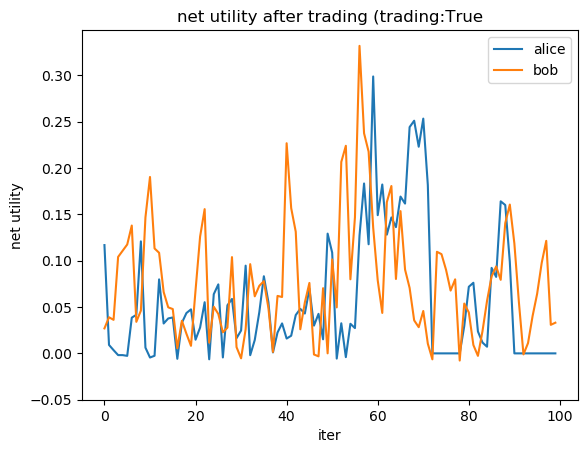

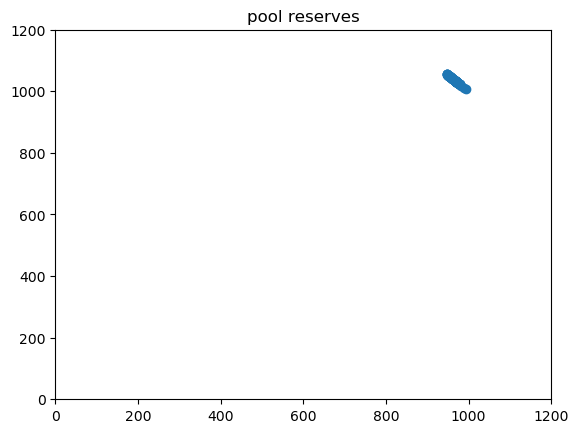

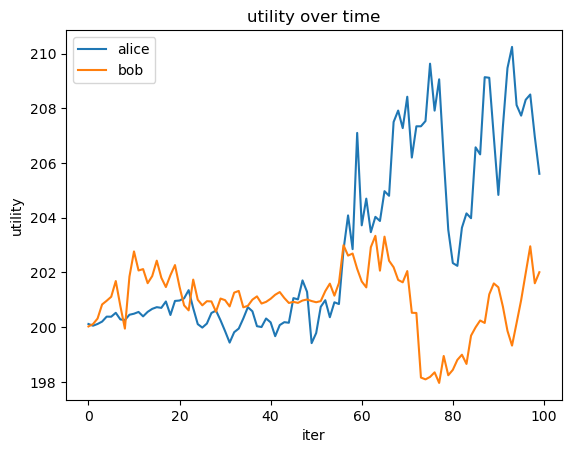

In [4]:
"""
Let's generate trades and report utility over time.
"""

import matplotlib.pyplot as plt

def scenario2(do_trades=False):
    # Preferences are expressed as utility weights over tokens.
    # These can drift over time
    preferences = {"alice":[1.01,0.99],  # Alice would prefer to buy tokenA
                   "bob"  :[1.0,1.0]}

    def utility(pref, portfolio):
        assert len(pref) == len(portfolio) == 2
        return pref[0] * portfolio[0] + pref[1] * portfolio[1]

    chain = Chain()

    num_iters = 100
    driftAlice = np.exp(np.random.normal(loc=0., scale=1e-2, size=num_iters))
    driftBob   = np.exp(np.random.normal(loc=0., scale=1e-2, size=num_iters))

    # Measure the social welfare due to use of the AMM
    net_utility_due_to_trades = 0.0

    diffs_alice = []
    diffs_bob   = []
    utils_alice = []
    utils_bob   = []
    xs = []
    poolAs = []
    poolBs = []
    for i in range(num_iters):

        # Sample a drift in preferences
        preferences['alice'][0] = round(    preferences['alice'][0] * driftAlice[i] * 1e3) / 1e3
        preferences['alice'][1] = round(1.0/preferences['alice'][0]                 * 1e3) / 1e3
        preferences['bob'  ][0] = round(    preferences['bob'  ][0] * driftBob[i]   * 1e3) / 1e3
        preferences['bob'  ][1] = round(1.0/preferences['bob'  ][0]                 * 1e3) / 1e3

        # The party tries to trade, in the direction of the top-of-block price
        def make_trade(sndr,prefs,portf):
            my_price = prefs[0] / prefs[1]
            pool_price = chain.pool_price()
            
            # Trade just a wee bit, compute a slippage limit based on reserve price
            if pool_price > 1.00001 * my_price:
                # Want to sell A
                qty =  3.e0
                slip = round((-qty / my_price) * 1e3) / 1e3
            elif pool_price < 0.99999 * my_price:
                # Want to sell B
                qty = -3.e0
                slip = round((qty * my_price) * 1e3) / 1e3
            else:
                qty = 0
                slip = 0
            return create_swap(sndr, qty, slip)
        
        if do_trades:
            # Apply Alice's trade, recording utility before and after
            util_a_old = utility(preferences['alice'], chain.accounts['alice'])
            txA = make_trade('alice', preferences['alice'], chain.accounts['alice'])
            try: chain.apply(txA)
            except ExecutionException as e: pass # print(e)
            util_a_new = utility(preferences['alice'], chain.accounts['alice'])

            # Apply Bob's trade, recording utility before and after
            util_b_old = utility(preferences['bob'  ], chain.accounts['bob'  ])
            txB = make_trade('bob'  , preferences['bob'  ], chain.accounts['bob'  ])
            try: chain.apply(txB)
            except ExecutionException as e: pass # print(e)
            util_b_new = utility(preferences['bob'  ], chain.accounts['bob'  ])
        else:
            util_a_new = util_a_old = utility(preferences['alice'], chain.accounts['alice'])
            util_b_new = util_b_old = utility(preferences['bob'  ], chain.accounts['bob'  ])

        poolAs.append(chain.poolA)
        poolBs.append(chain.poolB)
        utils_alice.append(util_a_new)
        utils_bob  .append(util_b_new)
        diffs_alice.append(util_a_new-util_a_old)
        diffs_bob  .append(util_b_new-util_b_old)
        xs.append(i)

        # Did my utility increase?
        net_utility_due_to_trades += \
            (util_a_new - util_a_old) + \
            (util_b_new - util_b_old)

    # Draw the immediate net change in utility due to trading
    plt.figure(0)
    plt.clf()
    plt.plot(xs,diffs_alice,xs,diffs_bob)
    plt.xlabel('iter')
    plt.ylabel('net utility')
    plt.title(f'net utility after trading (trading:{do_trades}')
    plt.ylim(ymin=-0.05)
    plt.legend(['alice','bob'])

    # Scatter plot the pool prices
    plt.figure(2)
    plt.clf()
    plt.title('pool reserves')
    plt.scatter(poolAs,poolBs)
    plt.ylim([0,1200])
    plt.xlim([0,1200])

    # Draw the overall social welfare (sums of utility)
    plt.figure(1)
    plt.clf()
    plt.plot(xs,utils_alice,xs,utils_bob)
    plt.xlabel('iter')
    plt.ylabel('utility')
    plt.title('utility over time')
    plt.legend(['alice','bob'])
    plt.show()

    
# Hypotheses about this scenario:
# - Trades are always profitable
scenario2(do_trades=True)
